In [106]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from datetime import datetime
import pickle

df = pd.read_csv('../data/modified_cases_train.csv')
df = df.dropna(subset=['sex'])

# Task 2.1:
# this will shuffle all rows in the dataframe and split 8:2 dataframe
train_df, test_df = train_test_split(df, test_size=0.2)

print(train_df.head())



        age     sex      province      country  latitude  longitude  \
92974     3    male  Metro Manila  Philippines  14.63000  121.03000   
14834     3  female       Sachsen      Germany  51.17964   14.42426   
106643    3  female         Choco     Colombia   5.70990  -76.62021   
127533    4  female    Tamil Nadu        India  13.08362   80.28252   
24824     3    male          Lima         Peru -12.03818  -76.89318   

       date_confirmation          outcome  
92974         11.05.2020  nonhospitalized  
14834         11.04.2020  nonhospitalized  
106643        19.04.2020  nonhospitalized  
127533        20.05.2020     hospitalized  
24824         24.04.2020  nonhospitalized  


Removing space in **province** and **country** column

In [107]:
df['province'].replace(' ', '_', regex=True, inplace=True)
df['country'].replace(' ', '_', regex=True, inplace=True)
X = df.drop('outcome', axis=1).copy()
y = df['outcome'].copy()


**We need to do One-Hot Encoding with the categorical data before using them to build the XGBoost tree**
**Also we need to convert the date_confirmation to datetime format.**

In [108]:
X['date_confirmation'] = pd.to_datetime(X['date_confirmation'],format='%d.%m.%Y')
X['date_confirmation'] = X.apply(lambda x: (datetime.now() - x['date_confirmation']).days, axis=1)
X_encoded = pd.get_dummies(X, columns=['country', 'province', 'sex'])


In [109]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y , test_size=0.2, random_state=42)
X_train.head()

print(len(X_train))
print(len(X_test))

125711
31428


In [110]:
clf_xgb = xgb.XGBClassifier(objective='multi:softmax', missing=None, seed=42, num_class=4, n_estimators=80)
clf_xgb.fit(X_train, 
            y_train,
            verbose=True, 
            early_stopping_rounds=10,
            eval_metric='mlogloss',
            eval_set=[(X_test, y_test)])

# save the model as .pkl file
pkl_filename = '../models/xgb_classifier.pkl'
pickle.dump(clf_xgb, open(pkl_filename, 'wb'))

[0]	validation_0-mlogloss:0.87332
Will train until validation_0-mlogloss hasn't improved in 10 rounds.
[1]	validation_0-mlogloss:0.60945
[2]	validation_0-mlogloss:0.44315
[3]	validation_0-mlogloss:0.33098
[4]	validation_0-mlogloss:0.25273
[5]	validation_0-mlogloss:0.19701
[6]	validation_0-mlogloss:0.15691
[7]	validation_0-mlogloss:0.12787
[8]	validation_0-mlogloss:0.10664
[9]	validation_0-mlogloss:0.09105
[10]	validation_0-mlogloss:0.07953
[11]	validation_0-mlogloss:0.07105
[12]	validation_0-mlogloss:0.06483
[13]	validation_0-mlogloss:0.06000
[14]	validation_0-mlogloss:0.05645
[15]	validation_0-mlogloss:0.05389
[16]	validation_0-mlogloss:0.05192
[17]	validation_0-mlogloss:0.05043
[18]	validation_0-mlogloss:0.04930
[19]	validation_0-mlogloss:0.04845
[20]	validation_0-mlogloss:0.04768
[21]	validation_0-mlogloss:0.04704
[22]	validation_0-mlogloss:0.04660
[23]	validation_0-mlogloss:0.04626
[24]	validation_0-mlogloss:0.04593
[25]	validation_0-mlogloss:0.04565
[26]	validation_0-mlogloss:0.04

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, monotone_constraints='()',
              n_estimators=80, n_jobs=0, num_class=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=42, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

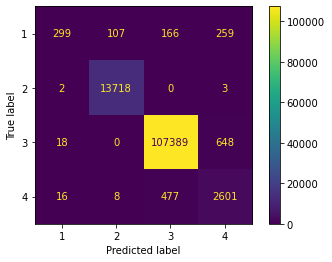

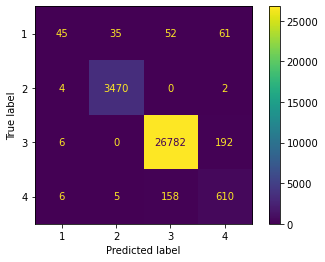

In [112]:
# evaluating model
# deceased=1, hospitalized=2, nonhospitalized=3, recovered=4
plot_confusion_matrix(clf_xgb, X_train, y_train, values_format='d',
                     display_labels=[1, 2, 3, 4])
plot_confusion_matrix(clf_xgb, X_test, y_test, values_format='d',
                     display_labels=[1, 2, 3, 4])
